# German Elections Analysis

This notebook contains

1. Loading and cleaning the dataset into a DataFrame
2. Exploratory Analysis
3. Obtention of a model

## 0. Importing all necessary packages

In [261]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime

## 1. Loading the dataset into a DataFrame

Defining important constants:

In [262]:
# download from https://drive.google.com/file/d/1f1DvjpOt31YZUPeRe3_tszGdDtyY6dK2/view?usp=share_link to content
# upload to local runtime
DS_PATH_DRIVE = '/content/EPINetz_TwitterPoliticians_2021.csv'
DS_PATH_LOCAL = 'data/EPINetz_TwitterPoliticians_2021.csv'
MAJORITY_THRESHOLD = 100 # officials


First the data is loaded from the file and then it is anonymized by eliminating the fields that are more related to the identity of a person. These fields will be irrelevant in our analysis.

The only id that will be kept is the __user_id__ to keep the relationship to Twitter.

The __until__ field will be dropped too, as every person in the list is currently in the German government.

In [263]:
try:
  df = pd.read_csv(DS_PATH_LOCAL)
except FileNotFoundError:
  df = pd.read_csv(DS_PATH_DRIVE)

df.drop(columns=['ID', 'until', 'abgeordnetenwatch_id', 'official_name', 'twitter_name', 'twitter_handle', 'wikidata_id'], inplace=True)
df.dropna(axis=0,how='any', inplace=True)

df = df.astype(
    {
        'year_of_birth':'int',
        'user_id': 'int'
        }
    )
df['from'] = pd.DatetimeIndex(df['from']).year

df['age_elected'] = df['from']-df['year_of_birth']
df.drop(columns=['from', 'year_of_birth'], inplace=True)

df.head()

,party,region,institution,office,user_id,gender,age_elected
0,SPD,Brandenburg,State Parliament,Parliamentarian,827090742162100224,female,43
1,DIE LINKE,Federal,Federal Parliament,Parliamentarian,1683845126,female,54
2,SPD,Federal,Federal Parliament,Parliamentarian,1377117206,female,44
3,FDP,Schleswig-Holstein,State Parliament,Parliamentarian,1073605033,male,56
4,DIE LINKE,Federal,Federal Parliament,Parliamentarian,551802475,female,52


## 2. Exploratory Analysis

The following analysis will be done to the data coming from the parties that most officials belong to.

In [264]:
parties = df.groupby(['party'])['user_id'].count().sort_values(ascending=False)

majority_parties = list(parties.loc[parties > MAJORITY_THRESHOLD].index)

majority_df = df.loc[df['party'].isin(majority_parties)].copy()

majority_df.head()

,party,region,institution,office,user_id,gender,age_elected
0,SPD,Brandenburg,State Parliament,Parliamentarian,827090742162100224,female,43
1,DIE LINKE,Federal,Federal Parliament,Parliamentarian,1683845126,female,54
2,SPD,Federal,Federal Parliament,Parliamentarian,1377117206,female,44
3,FDP,Schleswig-Holstein,State Parliament,Parliamentarian,1073605033,male,56
4,DIE LINKE,Federal,Federal Parliament,Parliamentarian,551802475,female,52


On the following Kernel Distribution Estimate (KDE) graphs it can be observed the distribution of ages at which officials are elected differentiated by party and gender.

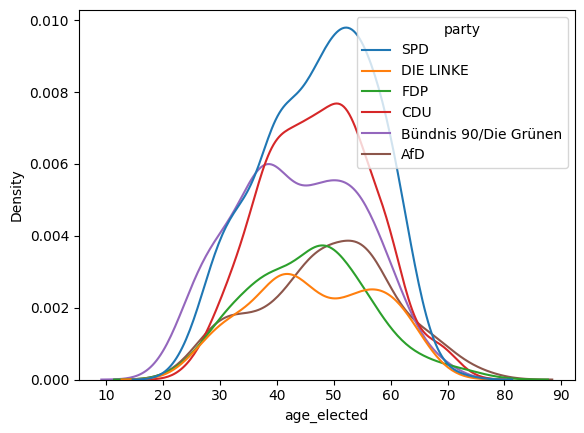

In [265]:
sns.kdeplot(x='age_elected', hue='party',data=majority_df)
plt.savefig("kde-party.png")

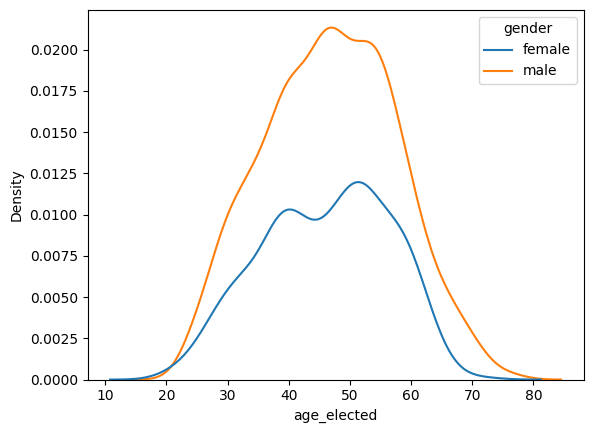

In [266]:
sns.kdeplot(x='age_elected', hue='gender',data=majority_df)
plt.savefig("kde-gender.png")


For both KDE plots the majority of officials fell in the range of 25 and 65 years old at the time of election.

For the final preprocessing step, the region, office and institution will be converted into numerical data by assigning a number to each field

In [267]:
majority_df.drop(['user_id'], axis=1, inplace = True)
majority_df.describe()


,age_elected
count,2311.000000
mean,46.519688
std,10.683662
min,19.000000
25%,39.000000
50%,47.000000
75%,55.000000
max,77.000000


/tmp/ipykernel_20816/981951830.py:14: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mask = np.triu(np.ones_like(majority_df.corr()))
/tmp/ipykernel_20816/981951830.py:15: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(majority_df.corr(),cmap="RdYlGn",mask = mask,annot=True)


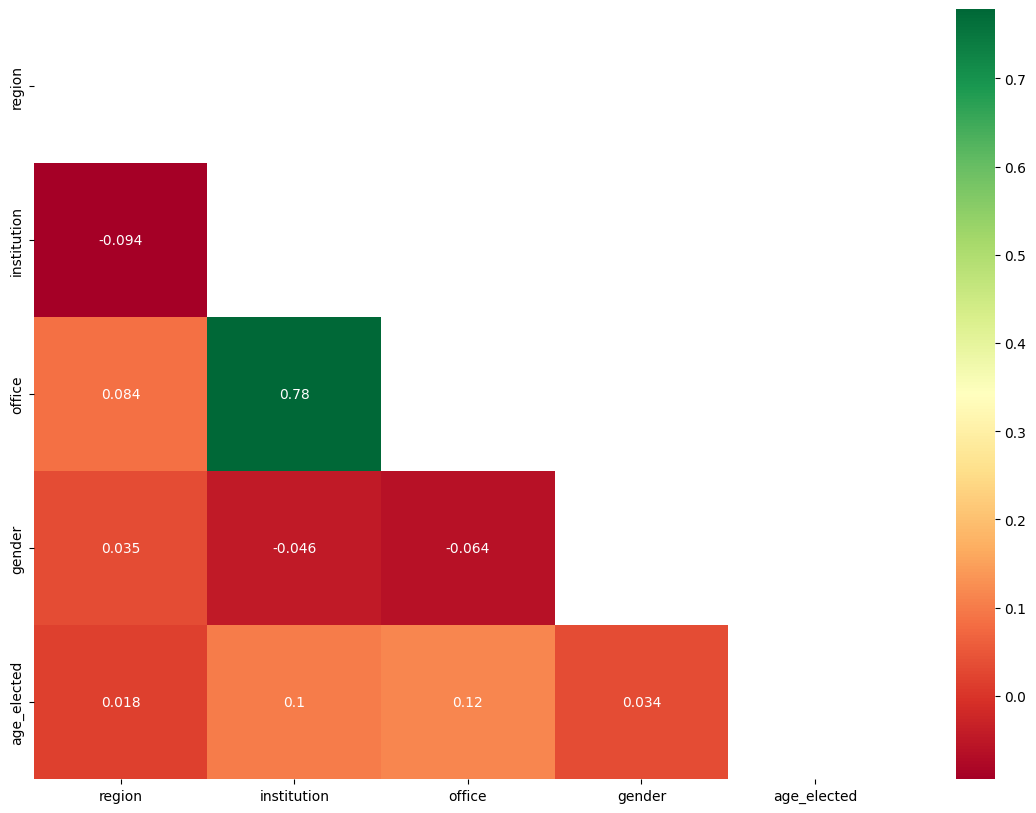

In [268]:
region_codes = {r:i for i, r in enumerate(majority_df['region'].unique())}
majority_df.replace(region_codes, inplace=True)

office_codes = {r:i for i, r in enumerate(majority_df['office'].unique())}
majority_df.replace(office_codes, inplace=True)

institution_codes = {r:i for i, r in enumerate(majority_df['institution'].unique())}
majority_df.replace(institution_codes, inplace=True)

gender_codes = {r:i for i, r in enumerate(majority_df['gender'].unique())}
majority_df.replace(gender_codes, inplace=True)

plt.figure(figsize = (14,10))
mask = np.triu(np.ones_like(majority_df.corr()))
sns.heatmap(majority_df.corr(),cmap="RdYlGn",mask = mask,annot=True)
plt.show()

## 3. Obtention of the Machine Learning Model

The model to obtain will predict the party given the age at which the the officers were elected, their region of origin, their institution, their office, and their gender

In [269]:

x = majority_df.iloc[:,1:]
y = majority_df['party']

display(majority_df.head())
display(x.head())
display(y.head())

,party,region,institution,office,gender,age_elected
0,SPD,0,0,0,0,43
1,DIE LINKE,1,1,0,0,54
2,SPD,1,1,0,0,44
3,FDP,2,0,0,1,56
4,DIE LINKE,1,1,0,0,52


,region,institution,office,gender,age_elected
0,0,0,0,0,43
1,1,1,0,0,54
2,1,1,0,0,44
3,2,0,0,1,56
4,1,1,0,0,52


0          SPD
1    DIE LINKE
2          SPD
3          FDP
4    DIE LINKE
Name: party, dtype: object

In [270]:
from sklearn.model_selection import StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=0)
train_idx, test_idx = next(sss.split(x, y))
x_train, y_train = x.iloc[train_idx], y.iloc[train_idx]
x_test, y_test = x.iloc[test_idx], y.iloc[test_idx]

In [318]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=7, random_state = 42)
clf.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

In [319]:
from sklearn import metrics
y_pred = clf.predict(x_test)
metrics.accuracy_score(y_test, y_pred)

0.2824207492795389

In [320]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(clf.classes_)
conf_matrix

['AfD' 'Bündnis 90/Die Grünen' 'CDU' 'DIE LINKE' 'FDP' 'SPD']


array([[ 11,   4,  20,   3,   0,  42],
       [  2,  36,  25,   5,   3,  68],
       [ 13,  16,  39,   2,   0,  76],
       [  2,  16,  16,   7,   1,  23],
       [  2,   8,  17,   0,   1,  44],
       [  4,  39,  42,   4,   1, 102]])

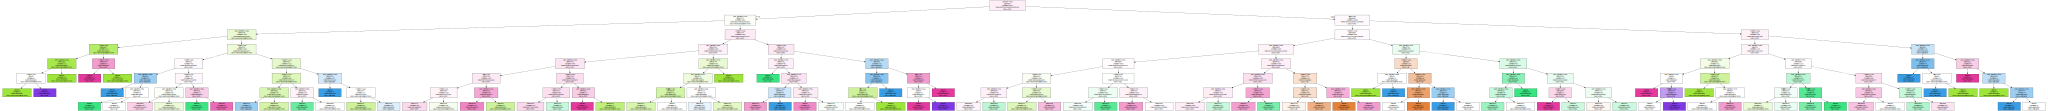

In [321]:
import graphviz
from sklearn import tree
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=x.columns,  
                                class_names=clf.classes_,
                                filled=True)
graph = graphviz.Source(dot_data, format="png") 
graph